# Introduction

This notebook is focused on getting a feel for the Perceptron.  This is similar information to the very nice [webpage](http://sebastianraschka.com/Articles/2015_singlelayer_neurons.html) by Sebastian Raschka, which has very good graphics. He covers all this material much better there, although his code is Python instead of Julia.  As with the other notebooks in this series, I hope it helps people get a better feel for using the [Julia](http://julialang.org/) programming language.

This notebook was originally designed as an adjunct to a [talk I gave](https://www.meetup.com/Monterey-Bay-Data-Science-Meetup/events/241814181/) on Aug 3rd, 2017 at [CSUMB](https://csumb.edu/) introducing neural networks.

I've updated the Julia code to version 1.1 for giving a [talk on Nov 19, 2019](https://www.meetup.com/Santa-Cruz-Machine-Learning-Meetup-Group/events/265387888/) at ProductOps for the Santa Cruz Machine Learning Meetup.

In [3]:
using Statistics

# Perceptron 

The **Perceptron** is the basic building block of a neural network, first described by Frank Rosenblatt in his 1957 paper, *The Perceptron--a perceiving and recognizing automaton*. It was conceived as a system that could take input and learn patterns through supervision. A single layer perceptron is able to learn any linearly separable pattern.

We will use it to linearly separate categories of flowers from the famous Iris dataset, based on the variables petal length and petal width.


## Get the data

Those with an R background are likely familiar with the Iris dataset.  Several popular R datasets are available in Julia through the `RDatasets` library.  To use dataframes in Julia, we have to import the library.

In [4]:
using DataFrames;
using RDatasets;
iris = dataset("datasets", "iris")

,SepalLength,SepalWidth,PetalLength,PetalWidth,Species
,Float64,Float64,Float64,Float64,Categorical…
1,5.1,3.5,1.4,0.2,setosa
2,4.9,3.0,1.4,0.2,setosa
3,4.7,3.2,1.3,0.2,setosa
4,4.6,3.1,1.5,0.2,setosa
5,5.0,3.6,1.4,0.2,setosa
6,5.4,3.9,1.7,0.4,setosa
7,4.6,3.4,1.4,0.3,setosa
8,5.0,3.4,1.5,0.2,setosa
9,4.4,2.9,1.4,0.2,setosa


## Peek at data

In [5]:
size(iris)

(150, 5)

In [6]:
# the `by` function allows examining a dataframe by a category variable
by(iris, :Species, nrow)

,Species,x1
,Categorical…,Int64
1,setosa,50
2,versicolor,50
3,virginica,50


In [7]:
# Julia uses `describe` to get a summary of basic statistics
describe(iris)

,variable,mean,min,median,max,nunique,nmissing,eltype
,Symbol,Union…,Any,Union…,Any,Union…,Nothing,DataType
1,SepalLength,5.84333,4.3,5.8,7.9,,,Float64
2,SepalWidth,3.05733,2.0,3.0,4.4,,,Float64
3,PetalLength,3.758,1.0,4.35,6.9,,,Float64
4,PetalWidth,1.19933,0.1,1.3,2.5,,,Float64
5,Species,,setosa,,virginica,3,,CategoricalString{UInt8}


In [8]:
# load plotting libraries
using Plots
using StatsPlots
gr(size=(800,600))

Plots.GRBackend()

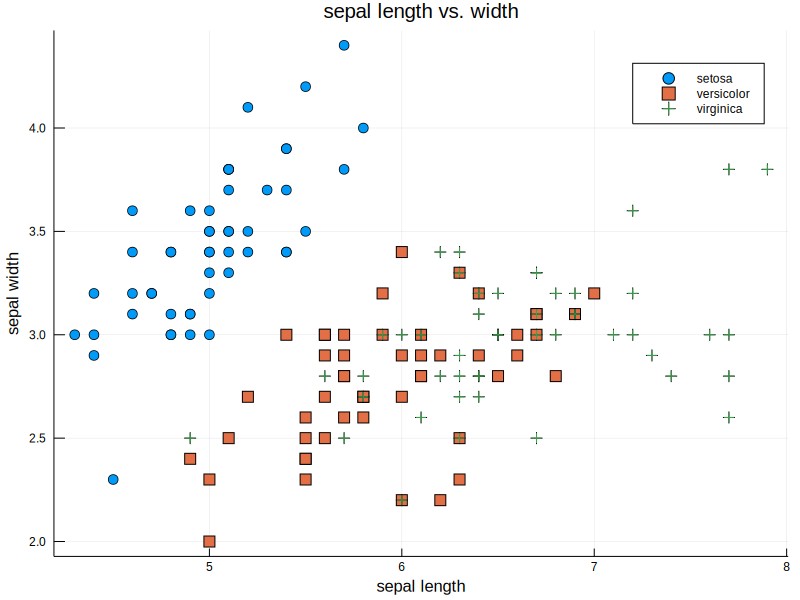

In [9]:
@df iris scatter(:SepalLength, :SepalWidth, group=:Species, title = "sepal length vs. width", 
xlabel = "sepal length", ylabel = "sepal width", marker=([:circle :rect :cross], 5))

So, there are 150 data points, with 50 of each species.  Using a perceptron, we are going to try to find the linear separation between setosa and non-setosa, using sepal length and sepal width.  

## The equations

![Perceptron](http://sebastianraschka.com/images/blog/2015/singlelayer_neural_networks_files/perceptron_schematic.png) Image by Sebastian Raschka from his [article](http://sebastianraschka.com/Articles/2015_singlelayer_neurons.html) as mentioned above.  

### implementation
We will implement the algorithm step by step to see what the data looks like, then implement it in a loop to see how many iterations it takes to converge.

In [12]:
# create targets
@time target = [s=="setosa" ? 1 : -1 for s in iris[!, :Species]]

  0.051062 seconds (78.20 k allocations: 3.795 MiB)


150-element Array{Int64,1}:
  1
  1
  1
  1
  1
  1
  1
  1
  1
  1
  1
  1
  1
  ⋮
 -1
 -1
 -1
 -1
 -1
 -1
 -1
 -1
 -1
 -1
 -1
 -1

For our data, we have two inputs corresponding to $x_1$ and $x_2$ in the equations above (sepal length and sepal width).  To create our data input array, we add a third column of 1's for the bias corresponding to $x_0$ above.

In [13]:
# to create input data array X, append a third column of 1's for the bias
@time X = hcat(iris[!, :SepalLength], iris[!, :SepalWidth], ones(150))

  0.000035 seconds (9 allocations: 5.266 KiB)


150×3 Array{Float64,2}:
 5.1  3.5  1.0
 4.9  3.0  1.0
 4.7  3.2  1.0
 4.6  3.1  1.0
 5.0  3.6  1.0
 5.4  3.9  1.0
 4.6  3.4  1.0
 5.0  3.4  1.0
 4.4  2.9  1.0
 4.9  3.1  1.0
 5.4  3.7  1.0
 4.8  3.4  1.0
 4.8  3.0  1.0
 ⋮            
 6.0  3.0  1.0
 6.9  3.1  1.0
 6.7  3.1  1.0
 6.9  3.1  1.0
 5.8  2.7  1.0
 6.8  3.2  1.0
 6.7  3.3  1.0
 6.7  3.0  1.0
 6.3  2.5  1.0
 6.5  3.0  1.0
 6.2  3.4  1.0
 5.9  3.0  1.0

In [14]:
# initialize weights w as small random numbers
@time w = rand(3).-0.5

  0.027893 seconds (98.36 k allocations: 4.813 MiB)


3-element Array{Float64,1}:
 -0.03489394221135522
  0.47004779728965485
 -0.11377214655293488

In [15]:
# calculate output (predicted y) from the product X*w, and squash
@time output = [o >= 0 ? 1 : -1 for o in X*w]

  0.146601 seconds (309.35 k allocations: 15.500 MiB, 5.65% gc time)


150-element Array{Int64,1}:
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 ⋮
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1

If you look at the equations, $\Delta w_0$ is simply multiplied by each of the members of our input X to get the weight changes.

$$\quad \Delta w_0 = \eta \,(target^{(0)} - output^{(0)})$$
$$\quad \Delta w_1 = \eta \,(target^{(1)} - output^{(1)})\,x_1^{(1)}$$
$$\quad \Delta w_2 = \eta \,(target^{(2)} - output^{(2)})\,x_2^{(2)}$$

means

$$\quad \Delta w_0 = \eta \,(target^{(0)} - output^{(0)})$$
$$\quad \Delta w_1 = \eta \,(\Delta w_0)\,x_1^{(1)}$$
$$\quad \Delta w_2 = \eta \,(\Delta w_0)\,x_2^{(2)}$$

In [16]:
# calculate delta Δw0
η = 0.1
@time delta = η*(target.-output)

  0.149563 seconds (426.96 k allocations: 21.413 MiB, 5.72% gc time)


150-element Array{Float64,1}:
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  ⋮  
 -0.2
 -0.2
 -0.2
 -0.2
 -0.2
 -0.2
 -0.2
 -0.2
 -0.2
 -0.2
 -0.2
 -0.2

In [17]:
error = count(x->x!=0, delta)/150

0.6666666666666666

In [18]:
@time [sum((X.*delta)[:,i]) for i in 1:3]

  0.236802 seconds (451.43 k allocations: 22.203 MiB, 4.39% gc time)


3-element Array{Float64,1}:
 -125.24000000000002 
  -57.440000000000005
  -19.999999999999996

In [19]:
# Julia has a cumsum function which is a bit more efficient
@time cumsum(X.*delta, dims=1)[end,:]

  0.173654 seconds (318.11 k allocations: 16.164 MiB, 9.29% gc time)


3-element Array{Float64,1}:
 -125.24000000000004
  -57.44000000000002
  -19.99999999999996

### loop with learning rate η = 0.1

In [37]:
# put into loop and save weights and errors for plotting, η = 0.1
epochs = 30
w = rand(3).-0.5
η = 0.1
errors = Float64[]
weights = Array{Float64}(undef,epochs,3)
for i in 1:epochs
    output = [o >= 0 ? 1 : -1 for o in X*w]
    delta = η*(target.-output)
    w += cumsum(X.*delta, dims=1)[end,:]
    weights[i,:] = w
    push!(errors, count(x->x!=0, delta)/150)
end
errors

30-element Array{Float64,1}:
 0.3333333333333333  
 0.6666666666666666  
 0.3333333333333333  
 0.3333333333333333  
 0.6666666666666666  
 0.3333333333333333  
 0.3333333333333333  
 0.6666666666666666  
 0.3333333333333333  
 0.3333333333333333  
 0.66                
 0.3333333333333333  
 0.3333333333333333  
 ⋮                   
 0.013333333333333334
 0.013333333333333334
 0.006666666666666667
 0.02                
 0.006666666666666667
 0.013333333333333334
 0.006666666666666667
 0.02                
 0.006666666666666667
 0.013333333333333334
 0.006666666666666667
 0.02                

In [22]:
weights

30×3 Array{Float64,2}:
   49.7187     34.7555     9.75584  
  -75.5213    -22.6845   -10.2442   
  -25.4613     11.5955    -0.244161 
   24.5987     45.8755     9.75584  
 -100.641     -11.5645   -10.2442   
  -50.5813     22.7155    -0.244161 
   -0.521259   56.9955     9.75584  
 -125.761      -0.44447  -10.2442   
  -75.7013     33.8355    -0.244161 
  -25.6413     68.1155     9.75584  
 -149.341      11.1955   -10.0442   
  -99.2813     45.4755    -0.0441607
  -49.2213     79.7555     9.95584  
    ⋮                               
  -47.3013     80.5555    10.5558   
  -47.6013     80.3355    10.5558   
  -46.7013     80.7955    10.7558   
  -48.0813     79.9755    10.5558   
  -47.1813     80.4355    10.7558   
  -47.4813     80.2155    10.7558   
  -46.5813     80.6755    10.9558   
  -47.9613     79.8555    10.7558   
  -47.0613     80.3155    10.9558   
  -47.3613     80.0955    10.9558   
  -46.4613     80.5555    11.1558   
  -47.8413     79.7355    10.9558   

If we plot the errors we saved above, we see that it jumps up and down between 1/3 and 2/3 until epoch 14 when it drops below 0.01.

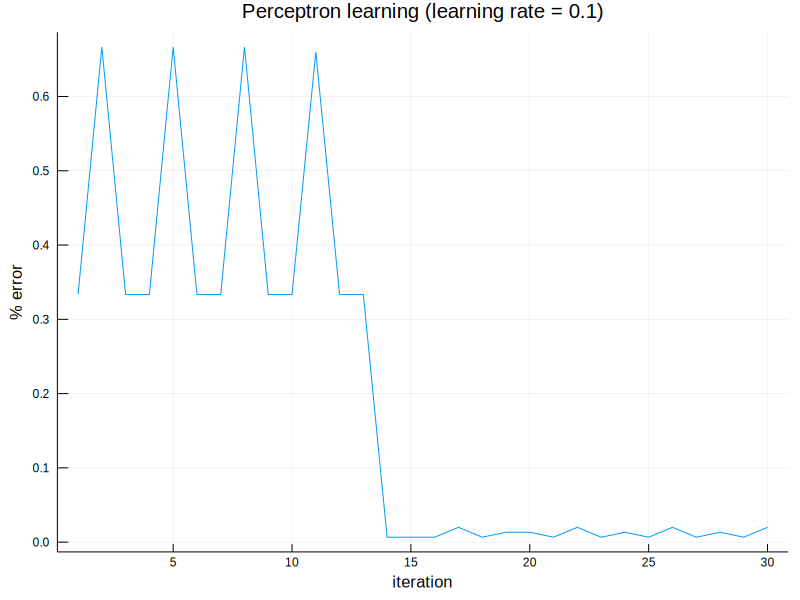

In [38]:
plot(errors, xlabel="iteration", ylabel="% error", legend=:none, 
title="Perceptron learning (learning rate = $η)")

### loop with learning rate η = 0.001
Let's see what happens when we make the learning rate smaller.

In [28]:
# loop η = .001
epochs = 60
w = rand(3).-0.5
η = 0.001
errors = Float64[]
weights = Array{Float64}(undef,epochs,3)
for i in 1:epochs
    output = [o >= 0 ? 1 : -1 for o in X*w]
    delta = η*(target.-output)
    w += cumsum(X.*delta, dims=1)[end,:]
    weights[i,:] = w
    push!(errors, count(x->x!=0, delta)/150)
end
errors

60-element Array{Float64,1}:
 0.44666666666666666 
 0.3333333333333333  
 0.3333333333333333  
 0.6666666666666666  
 0.3333333333333333  
 0.3333333333333333  
 0.6666666666666666  
 0.3333333333333333  
 0.3333333333333333  
 0.006666666666666667
 0.013333333333333334
 0.006666666666666667
 0.02                
 ⋮                   
 0.013333333333333334
 0.006666666666666667
 0.02                
 0.006666666666666667
 0.013333333333333334
 0.006666666666666667
 0.02                
 0.006666666666666667
 0.013333333333333334
 0.006666666666666667
 0.02                
 0.006666666666666667

As we expect, it takes longer to drop to find a set of solutions with lower learning rate

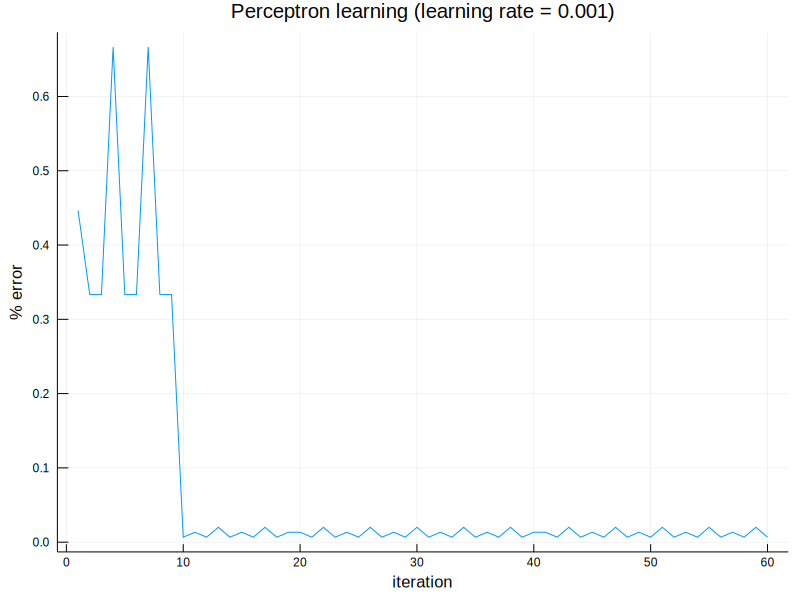

In [29]:
plot(errors, xlabel="iteration", ylabel="% error", legend=:none, 
title="Perceptron learning (learning rate = $η)")

Need to actually go out to 50 epochs

In [35]:
# loop η = .001
epochs = 50
w = rand(3).-0.5
η = 0.001
errors = Float64[]
weights = Array{Float64}(undef,epochs,3)
for i in 1:epochs
    output = [o >= 0 ? 1 : -1 for o in X*w]
    delta = η*(target.-output)
    w += cumsum(X.*delta, dims=1)[end,:]
    weights[i,:] = w
    push!(errors, count(x->x!=0, delta)/150)
end
errors

50-element Array{Float64,1}:
 0.6666666666666666  
 0.3333333333333333  
 0.3333333333333333  
 0.013333333333333334
 0.013333333333333334
 0.05333333333333334 
 0.30666666666666664 
 0.6666666666666666  
 0.3333333333333333  
 0.3333333333333333  
 0.6666666666666666  
 0.3333333333333333  
 0.3333333333333333  
 ⋮                   
 0.26666666666666666 
 0.3933333333333333  
 0.3333333333333333  
 0.013333333333333334
 0.013333333333333334
 0.013333333333333334
 0.013333333333333334
 0.013333333333333334
 0.013333333333333334
 0.013333333333333334
 0.006666666666666667
 0.013333333333333334

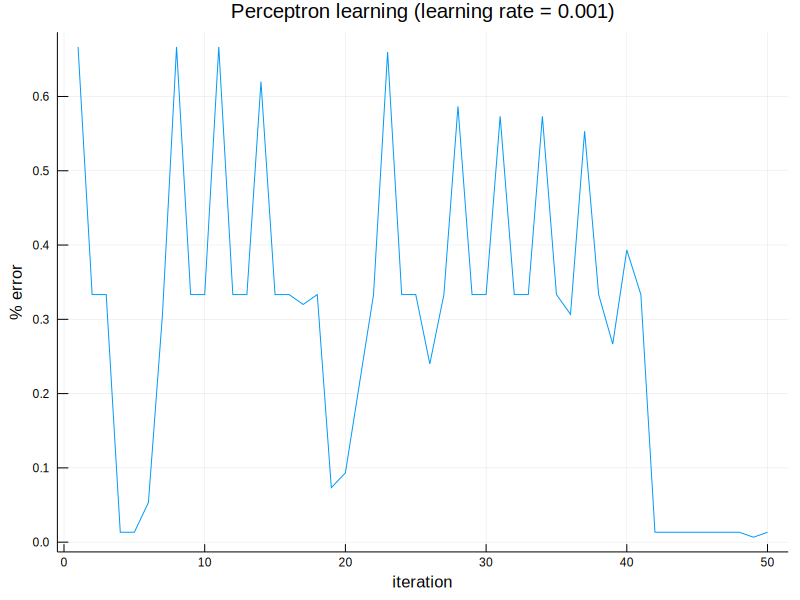

In [36]:
plot(errors, xlabel="iteration", ylabel="% error", legend=:none, 
title="Perceptron learning (learning rate = $η)")

### loop with learning rate η = 0.01

In [33]:
# loop η = .01
epochs = 30
w = rand(3).-0.5
η = 0.01
errors = Float64[]
weights = Array{Float64}(undef,epochs,3)
for i in 1:epochs
    output = [o >= 0 ? 1 : -1 for o in X*w]
    delta = η*(target.-output)
    w += cumsum(X.*delta, dims=1)[end,:]
    weights[i,:] = w
    push!(errors, count(x->x!=0, delta)/150)
end
errors

30-element Array{Float64,1}:
 0.3333333333333333 
 0.6666666666666666 
 0.3333333333333333 
 0.3333333333333333 
 0.6666666666666666 
 0.3333333333333333 
 0.3333333333333333 
 0.6666666666666666 
 0.3333333333333333 
 0.3333333333333333 
 0.6066666666666667 
 0.3333333333333333 
 0.3333333333333333 
 ⋮                  
 0.3333333333333333 
 0.6133333333333333 
 0.3333333333333333 
 0.3333333333333333 
 0.46               
 0.3333333333333333 
 0.31333333333333335
 0.6666666666666666 
 0.3333333333333333 
 0.3333333333333333 
 0.5533333333333333 
 0.3333333333333333 

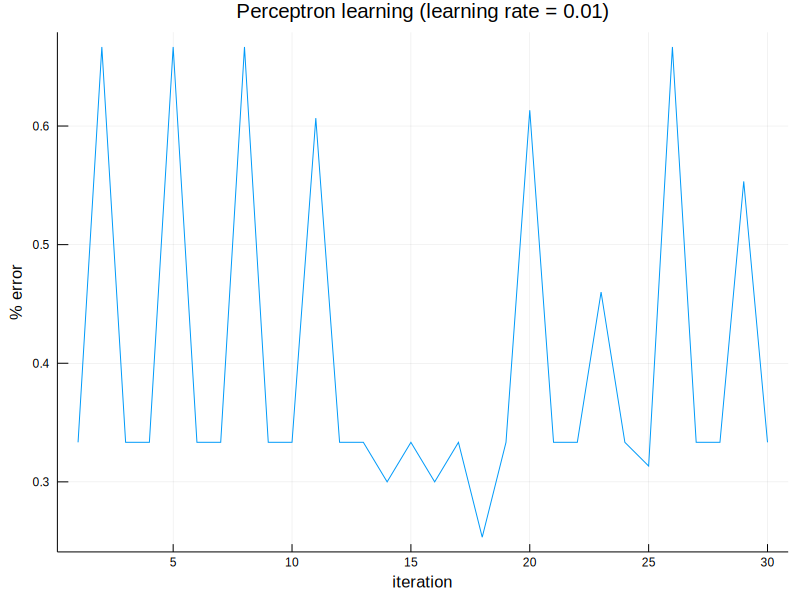

In [34]:
plot(errors, xlabel="iteration", ylabel="% error", legend=:none, 
title="Perceptron learning (learning rate = $η)")

### Identify decision boundary

To visualize the solutions that we come up with, let's plot the decision boundary.  If we are plotting sepal length vs sepal width, we can find out what line would be generated by the weights we calculated using the formula:

$ x_2 = \frac{-w_1}{w_2} x_1 - \frac{w_0}{w_2}$

since we are looking for the place where 

$ w_2 x_2 + w_1 x_1 + w_0 = 0$

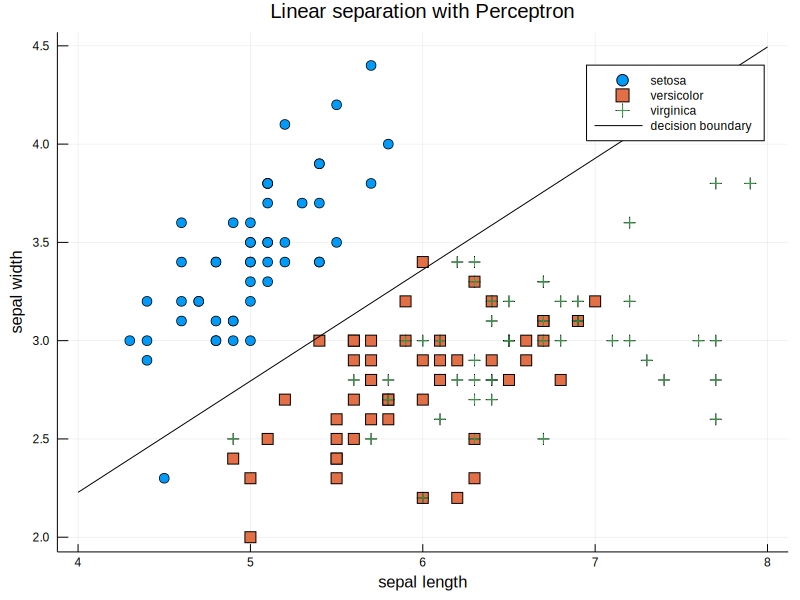

In [30]:
# in Julia, plot! modifies a previous plot
@df iris scatter(:SepalLength, :SepalWidth, group=:Species, title = "Linear separation with Perceptron", 
xlabel = "sepal length", ylabel = "sepal width", marker=([:circle :rect :cross], 5))
x = LinRange(4.0, 8.0, 50)
y = (-w[1]*x.-w[3])/w[2]
plot!(x,y, linecolor=:black, label="decision boundary")

The line above was calculated with the weights we got at the end of all iterations.  If we plot a few other lines from our saved weights (iterations =5, =10, =15 and =20), we can get a feel for how the solutions evolve in the learning process.  Note that when iterations = 5, the line doesn't show up in the plot below because it is not even in the chosen x and y limits.

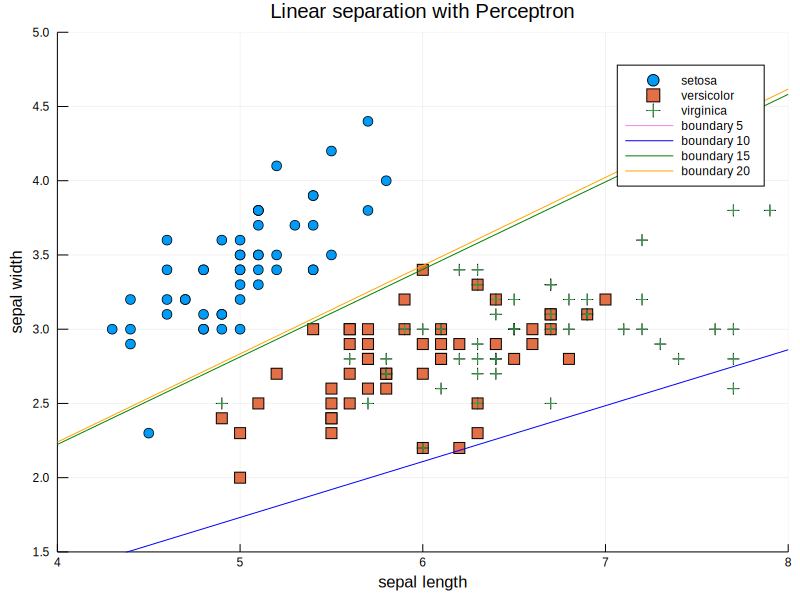

In [39]:
# draw boundaries at different numbers of iterations (note #5 isn't even in the plot frame)
xmin=4
xmax=8
ymin=1.5
ymax=5
@df iris scatter(:SepalLength, :SepalWidth, group=:Species, title = "Linear separation with Perceptron", 
xlabel = "sepal length", ylabel = "sepal width", marker=([:circle :rect :cross], 5))
x = LinRange(4.0, 8.0, 50)
i=5
y= (-weights[i,1]*x.-weights[i,3])/weights[i,2]
plot!(x,y, linecolor=[:violet, :blue, :green, :orange, :red][fld(i,5)], 
label="boundary $i", xlims=(xmin,xmax), ylims=(ymin,ymax))
i=10
y= (-weights[i,1]*x.-weights[i,3])/weights[i,2]
plot!(x,y, linecolor=[:violet, :blue, :green, :orange, :red][fld(i,5)], 
label="boundary $i", xlims=(xmin,xmax), ylims=(ymin,ymax))
i=15
y= (-weights[i,1]*x.-weights[i,3])/weights[i,2]
plot!(x,y, linecolor=[:violet, :blue, :green, :orange, :red][fld(i,5)], 
label="boundary $i", xlims=(xmin,xmax), ylims=(ymin,ymax))
i=20
y= (-weights[i,1]*x.-weights[i,3])/weights[i,2]
plot!(x,y, linecolor=[:violet, :blue, :green, :orange, :red][fld(i,5)], 
label="boundary $i", xlims=(xmin,xmax), ylims=(ymin,ymax))


# Adaline

The **ADA**pative **LI**near **NE**uron, developed by Widrow and Hoff (1960), uses a **linear activation function** to provide a graded feedback compared to Rosenblatt's original perceptron.  The weights are changed using the rule:

update weights ($w_j$) for data at $j$,
$$\quad \Delta w_j = \eta \,(target^{(j)} - output^{(j)}) \,x_i^{(j)}$$

Unlike the perceptron, this output is the weighted sum *without* squashing.  It is derived from taking the partial derviative of the cost function:

$$\quad J(\mathbf{w}) = \frac{1}{2} \sum\limits_{j}( target^{(j)} - output^{(j)} )^2$$

so that the update is in the opposite direction of the gradient:

$$\quad \Delta \mathbf{w} = - \eta\,\nabla \, J(\mathbf{w})$$

Thus, the term *gradient descent* for minimizing the cost function.


In [27]:
# here is the code from the perceptron for comparison
epochs = 30
w = rand(3).-0.5
η = 0.1
errors = Float64[]
weights = Array{Float64}(undef,epochs,3)
for i in 1:epochs
    output = [o >= 0 ? 1 : -1 for o in X*w]
    delta = η*(target.-output)
    w += cumsum(X.*delta, dims=1)[end,:]
    weights[i,:] = w
    push!(errors, count(x->x!=0, delta)/150)
end
errors

30-element Array{Float64,1}:
 0.3333333333333333  
 0.6666666666666666  
 0.3333333333333333  
 0.3333333333333333  
 0.6666666666666666  
 0.3333333333333333  
 0.3333333333333333  
 0.6666666666666666  
 0.3333333333333333  
 0.3333333333333333  
 0.66                
 0.3333333333333333  
 0.3333333333333333  
 ⋮                   
 0.013333333333333334
 0.013333333333333334
 0.006666666666666667
 0.02                
 0.006666666666666667
 0.013333333333333334
 0.006666666666666667
 0.02                
 0.006666666666666667
 0.013333333333333334
 0.006666666666666667
 0.02                

## loop with learning rate η = 0.01

In [40]:
# loop η = .01
# gradient doesn't descend if use an η like above (it explodes!)
epochs = 50
w = rand(3).-0.5
η = 0.01
costs = Float64[]
weights = Array{Float64}(undef,epochs,3)
for j in 1:epochs
    delta = η*(target.-(X*w))
    w += cumsum(X.*delta, dims=1)[end,:]
    weights[j,:] = w
    cost = (sum(abs2, target.-(X*w)))/2
    push!(costs, cost)
end
costs

50-element Array{Float64,1}:
 285238.7628210073          
      1.2625165871123714e9  
      5.588607608786505e12  
      2.473831689905732e16  
      1.0950568832881335e20 
      4.847336957197825e23  
      2.1457036556915902e27 
      9.498089814473686e30  
      4.204388144863913e34  
      1.861098391145475e38  
      8.238267025263883e41  
      3.64671980280301e45   
      1.6142430537118523e49 
      ⋮                     
      1.0132082760393039e144
      4.48502903980352e147  
      1.9853258173643837e151
      8.78816740340711e154  
      3.8901366030103977e158
      1.7219930043906843e162
      7.622508435502692e165 
      3.374150458286495e169 
      1.4935885491616588e173
      6.611462001370576e176 
      2.9266045069843327e180
      1.2954795684412101e184

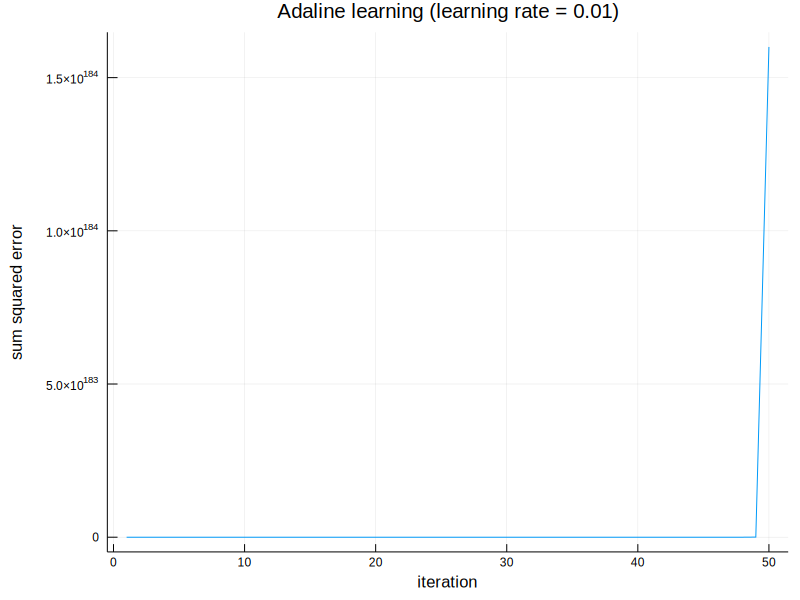

In [29]:
plot(costs, xlabel="iteration", ylabel="sum squared error", legend=:none, 
title="Adaline learning (learning rate = $η)")

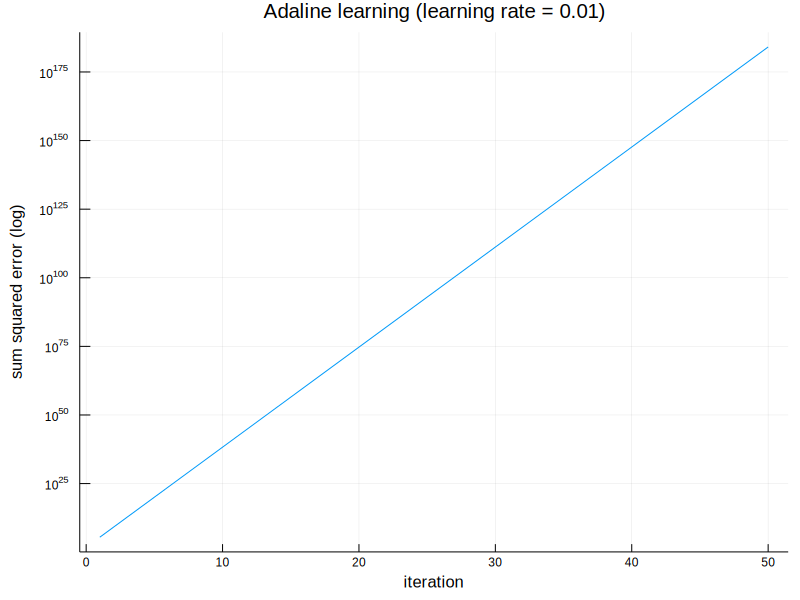

In [41]:
plot(costs, yscale=:log10, xlabel="iteration", ylabel="sum squared error (log)", legend=:none, 
title="Adaline learning (learning rate = $η)")

## loop with learning rate η = 0.0001

In [42]:
# loop η = .0001
epochs = 50
w = rand(3).-0.5
η = 0.0001
costs = Float64[]
weights = Array{Float64}(undef,epochs,3)
for j in 1:epochs
    delta = η*(target.-(X*w))
    w += cumsum(X.*delta, dims=1)[end,:]
    weights[j,:] = w
    cost = (sum(abs2, target.-(X*w)))/2
    push!(costs, cost)
end
costs

50-element Array{Float64,1}:
 146.03417341021103 
  89.03275624301418 
  82.41916014315157 
  81.12316863741248 
  80.39367100898389 
  79.72977267618506 
  79.07861375280986 
  78.43456425377552 
  77.79697348050867 
  77.16571619080683 
  76.54072309524054 
  75.92193135912208 
  75.30927937917706 
   ⋮                
  61.3476132036392  
  60.87956960437343 
  60.41616998741546 
  59.957368273869044
  59.50311884204593 
  59.053376522929184
  58.608096595681786
  58.1672347831996  
  57.73074724770852 
  57.29859058640533 
  56.87072182714181 
  56.447098424151626

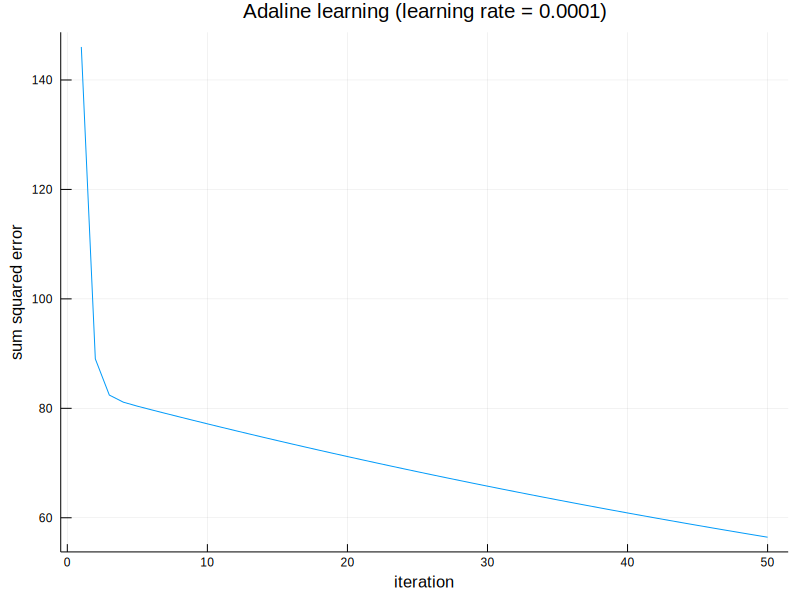

In [43]:
plot(costs, xlabel="iteration", ylabel="sum squared error", legend=:none, 
title="Adaline learning (learning rate = $η)")

## loop with learning rate η = 0.00001

In [33]:
# loop η = .00001
epochs = 50
w = rand(3).-0.5
η = 0.00001
costs = Float64[]
weights = Array{Float64}(undef,epochs,3)
for j in 1:epochs
    delta = η*(target.-(X*w))
    w += cumsum(X.*delta, dims=1)[end,:]
    weights[j,:] = w
    cost = (sum(abs2, target.-(X*w)))/2
    push!(costs, cost)
end
costs

50-element Array{Float64,1}:
 167.76317274937225 
 150.38766885497213 
 135.2770849894618  
 122.13584222564045 
 110.70693592408749 
 100.76690162673106 
  92.1214379224324  
  84.60160054698011 
  78.0604931690062  
  72.37039004222798 
  67.42023416364711 
  63.11346193260241 
  59.36611170094554 
   ⋮                
  34.66838447041562 
  34.56321035159927 
  34.469204298247966
  34.384911374333306
  34.30906651655501 
  34.24056975515559 
  34.178464668522714
  34.1219196495564  
  34.07021161685383 
  34.022711851652964
  33.97887368311444 
  33.93822178072583 

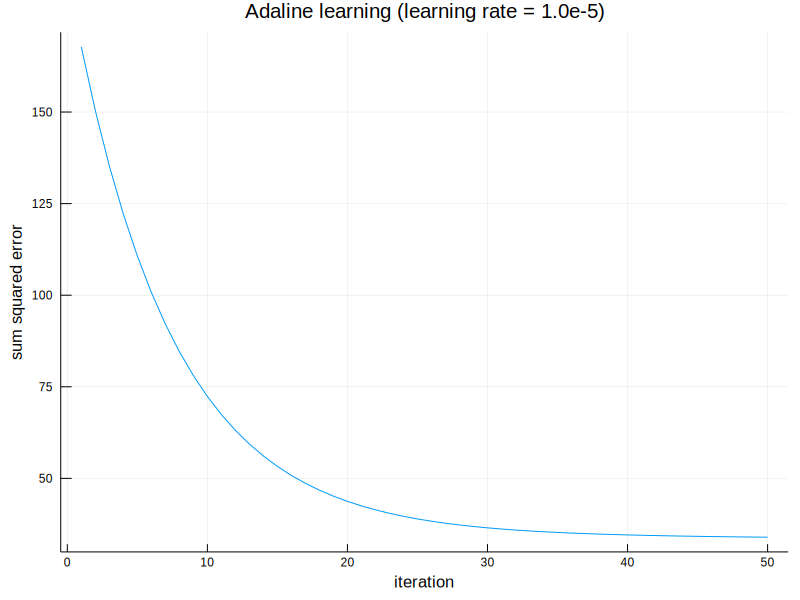

In [34]:
plot(costs, xlabel="iteration", ylabel="sum squared error", legend=:none, 
title="Adaline learning (learning rate = $η)")

In [35]:
weights

50×3 Array{Float64,2}:
 -0.135519  0.45496   0.358836
 -0.147507  0.449271  0.356899
 -0.158699  0.443994  0.355097
 -0.16915   0.439099  0.353419
 -0.17891   0.434562  0.351858
 -0.188025  0.430357  0.350405
 -0.196538  0.426463  0.349054
 -0.204491  0.422858  0.347797
 -0.211921  0.419524  0.346629
 -0.218863  0.416441  0.345542
 -0.225351  0.413593  0.344532
 -0.231415  0.410963  0.343594
 -0.237084  0.408538  0.342722
  ⋮                           
 -0.30567   0.386111  0.333331
 -0.306705  0.386073  0.33324 
 -0.307685  0.386064  0.333157
 -0.308612  0.386082  0.333084
 -0.309491  0.386124  0.333019
 -0.310324  0.38619   0.332961
 -0.311115  0.386277  0.332911
 -0.311867  0.386385  0.332867
 -0.312582  0.386511  0.332829
 -0.313262  0.386654  0.332797
 -0.313911  0.386814  0.33277 
 -0.314529  0.386989  0.332749

## Scaling
We can start the process in a better range if we normalize the input data around zero.  This will help the process zero in faster.

In [50]:
# scale data
Xs = Array{Float64}(undef, 150,3)
for i in 1:3
    Xs[:,i] = convert(Array, X[:,i].-Statistics.mean(X[:,i]))./std(X[:,i]);
end
Xs[:,3] = rand(150).-0.5
Xs

150×3 Array{Float64,2}:
 -0.897674    1.0156     -0.33527  
 -1.1392     -0.131539    0.150102 
 -1.38073     0.327318   -0.0737293
 -1.50149     0.0978893  -0.418584 
 -1.01844     1.24503     0.485188 
 -0.535384    1.93331     0.225613 
 -1.50149     0.786174   -0.212607 
 -1.01844     0.786174    0.193534 
 -1.74302    -0.360967   -0.238101 
 -1.1392      0.0978893  -0.350043 
 -0.535384    1.47446     0.132263 
 -1.25996     0.786174    0.445958 
 -1.25996    -0.131539   -0.450483 
  ⋮                                
  0.189196   -0.131539   -0.291508 
  1.27607     0.0978893  -0.335894 
  1.03454     0.0978893   0.391401 
  1.27607     0.0978893  -0.216794 
 -0.0523308  -0.819823   -0.262303 
  1.1553      0.327318   -0.449911 
  1.03454     0.556746   -0.252071 
  1.03454    -0.131539   -0.305214 
  0.551486   -1.27868     0.120528 
  0.793012   -0.131539   -0.489577 
  0.430722    0.786174    0.265956 
  0.0684325  -0.131539   -0.0328858

## loop with learning rate η = 0.001

In [51]:
# loop with scaling data η = .001
epochs = 20
w = rand(3).-0.5
η = 0.001
costs = Float64[]
weights = Array{Float64}(undef, epochs,3)
for i in 1:epochs
    delta = η*(target.-(Xs*w))
    w += cumsum(Xs.*delta, dims=1)[end,:]
    weights[i,:] = w
    cost = (sum(abs2, target.-(Xs*w)))/2
    push!(costs, cost)
end
costs

20-element Array{Float64,1}:
 45.137198160504624
 38.64462236448352 
 34.02529861971254 
 30.73393396047286 
 28.38518103632474 
 26.70641086845401 
 25.50451016984793 
 24.642518247749155
 24.023172438064353
 23.57730795527149 
 23.255671645066112
 23.023138715940163
 22.854622465328493
 22.73217796796357 
 22.64294866802153 
 22.577708689758825
 22.529826653540756
 22.494528090250586
 22.46836965136598 
 22.448863742174453

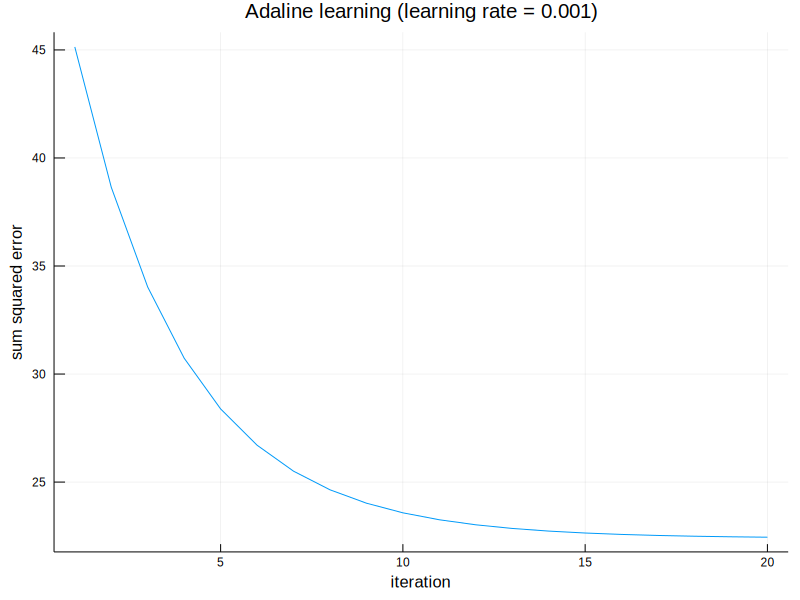

In [52]:
plot(costs, xlabel="iteration", ylabel="sum squared error", legend=:none, 
title="Adaline learning (learning rate = $η)")

## loop with learning rate η = 0.01

In [39]:
# loop with scaling data η = .01
epochs = 20
w = rand(3).-0.5
η = 0.01
costs = Float64[]
weights = Array{Float64}(undef, epochs,3)
for i in 1:epochs
    delta = η*(target.-(Xs*w))
    w += cumsum(Xs.*delta, dims=1)[end,:]
    weights[i,:] = w
    cost = (sum(abs2, target.-(Xs*w)))/2
    push!(costs, cost)
end
costs

20-element Array{Float64,1}:
 44.439172908691475
 32.00374432780928 
 26.674060910620696
 24.332973096292005
 23.29882303586227 
 22.841417802229405
 22.639049525746156
 22.549510686316548
 22.509893219793618
 22.492363970010963
 22.484607925886916
 22.48117616292677 
 22.479657734556532
 22.478985886074895
 22.47868861793111 
 22.47855708775464 
 22.478498890508543
 22.478473140376174
 22.478461746893473
 22.478456705698097

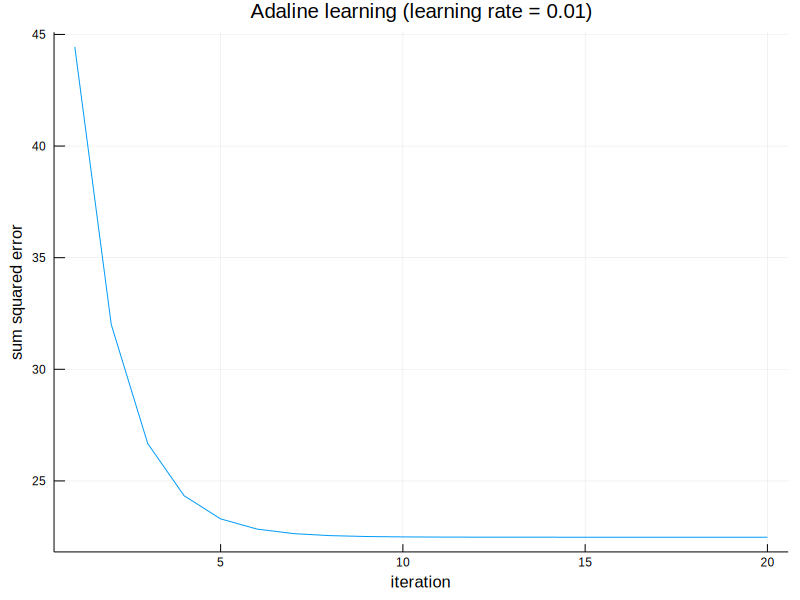

In [40]:
plot(costs, xlabel="iteration", ylabel="sum squared error", legend=:none, 
title="Adaline learning (learning rate = $η)")

## Plot decision boundary

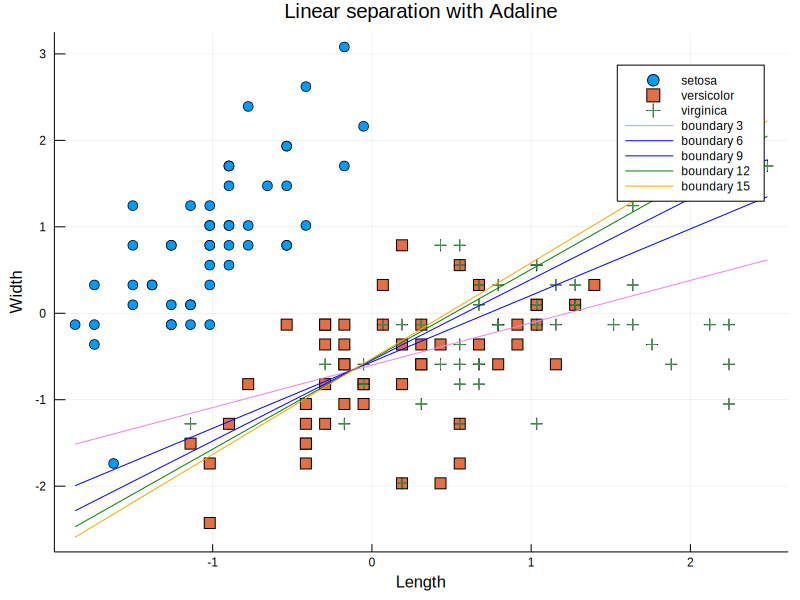

In [53]:
scatter(Xs[:,1],Xs[:,2], group=iris[!, :Species], title = "Linear separation with Adaline", 
xlabel = "Length", ylabel = "Width", marker=([:circle :rect :cross], 5))

x = LinRange(minimum(Xs[:,1]), maximum(Xs[:,1]), 50)
i=3
y= (-weights[i,1]*x.-weights[i,3])/weights[i,2]
plot!(x,y, linecolor=[:violet, :blue, :green, :orange, :red][fld(i,5)+1], 
label="boundary $i")
i=6
y= (-weights[i,1]*x.-weights[i,3])/weights[i,2]
plot!(x,y, linecolor=[:violet, :blue, :green, :orange, :red][fld(i,5)+1], 
label="boundary $i")
i=9
y= (-weights[i,1]*x.-weights[i,3])/weights[i,2]
plot!(x,y, linecolor=[:violet, :blue, :green, :orange, :red][fld(i,5)+1], 
label="boundary $i")
i=12
y= (-weights[i,1]*x.-weights[i,3])/weights[i,2]
plot!(x,y, linecolor=[:violet, :blue, :green, :orange, :red][fld(i,5)+1], 
label="boundary $i")
i=15
y= (-weights[i,1]*x.-weights[i,3])/weights[i,2]
plot!(x,y, linecolor=[:violet, :blue, :green, :orange, :red][fld(i,5)+1], 
label="boundary $i")

# Multi Layer Perceptrons

$\frac{\partial E^n}{\partial w_{ji}}$


[<img style="float: left;" src="https://i.creativecommons.org/l/by-sa/4.0/88x31.png">](http://creativecommons.org/licenses/by-sa/4.0/)  

Licensed under a [Creative Commons Attribution-ShareAlike 4.0 International License](http://creativecommons.org/licenses/by-sa/4.0/).